In [1]:
import pandas as pd
import scanpy as sc
from scipy.spatial import cKDTree
from tqdm import tqdm
import matplotlib.pyplot as plt
import anndata as ad
import numpy as np
import os
import warnings
from scipy.stats import pearsonr
import seaborn as sns
import re
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import umap
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

warnings.filterwarnings('ignore')

/mnt/Data16Tc/home/haichao/anaconda3/envs/SpaCon_clone/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/Data16Tc/home/haichao/anaconda3/envs/SpaCon_clone/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/Data16Tc/home/haichao/anaco

In [2]:
ctx_43_regions = ['FRP', 'MOp', 'MOs', 'SSp-n', 'SSp-bfd', 'SSp-ll', 'SSp-m', 'SSp-ul', 'SSp-tr', 'SSp-un', 'SSs', 'GU', 'VISC', 'AUDd', 'AUDp', 'AUDpo', 'AUDv', 'VISal', 'VISam', 'VISl', 'VISp', 'VISpl', 'VISpm', 'VISli', 'VISpor', 'ACAd', 'ACAv', 'PL', 'ILA', 'ORBl', 'ORBm', 'ORBvl', 'AId', 'AIp', 'AIv', 'RSPagl', 'RSPd', 'RSPv', 'VISa', 'VISrl', 'TEa', 'PERI', 'ECT']


### conn data

In [3]:
mcc = MouseConnectivityCache(resolution=100)
structure_tree = mcc.get_structure_tree()
annotation = mcc.get_annotation_volume()[0]
cc_coor = []
for x in tqdm(range(132)):
    for y in range(80):
        for z in range(59):
            point = tuple((x,y,z))
            point_id = annotation[point]
            # print(point_id)
            if point_id == 0:
                continue
            parent = structure_tree.ancestor_ids([point_id])[0][0]
            parent_name = structure_tree.get_structures_by_id([parent])[0]['acronym']
            if parent_name.startswith('cc'):
                cc_coor.append([x,y,z])
len(cc_coor)

 11%|█         | 14/132 [00:00<00:01, 59.79it/s]

100%|██████████| 132/132 [00:04<00:00, 29.30it/s]


2438

In [4]:
# cc_coor = pd.read_csv('./cc_xyz_coor_100um.csv')
file_path = '/mnt/Data16Ta/feiyao/tracing_for_haichao/results/'
files = os.listdir(file_path)
files = [i for i in files if 'npy' in i]
ctx2cc_conn_list = []
idx = []
for f in files:
    ctx_region = f.split('-')[1]
    if f.split('-')[2] != 'mean_mean':
        ctx_region = f"{f.split('-')[1]}-{f.split('-')[2]}"
    tmp = np.load(file_path + f)
    conn_tmp = [tmp[x, y, z] for x, y, z in cc_coor]
    ctx2cc_conn_list.append(conn_tmp)
    idx.append(ctx_region)
ctx2cc_conn = pd.DataFrame(data=ctx2cc_conn_list, index=idx, dtype=float)
ctx2cc_conn = ctx2cc_conn.loc[:, (ctx2cc_conn != 0).any(axis=0)]
ctx2cc_conn_raw = ctx2cc_conn.copy()
ctx2cc_conn.shape

(43, 98)

In [5]:
ctx2cc_conn = ctx2cc_conn.transpose()

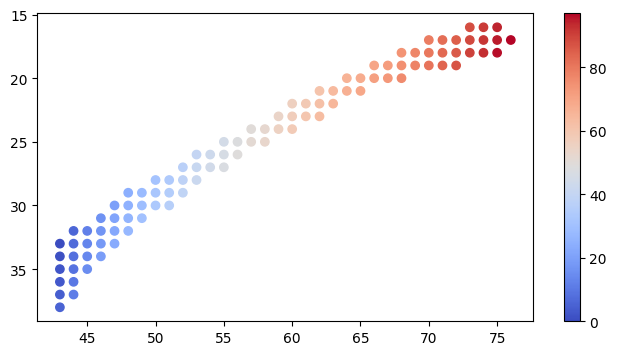

In [42]:
coor = [cc_coor[i] for i in ctx2cc_conn_raw.columns]
coor = np.array(coor)
plt.figure(figsize=(8,4))
plt.scatter(coor[:, 0], coor[:, 1], c=np.arange(coor.shape[0]), cmap='coolwarm')
plt.gca().invert_yaxis()
plt.colorbar()
plt.savefig('./cc/cc_id_map.pdf', format='pdf')

In [5]:
ctx2cc_conn.columns = range(ctx2cc_conn.shape[1])


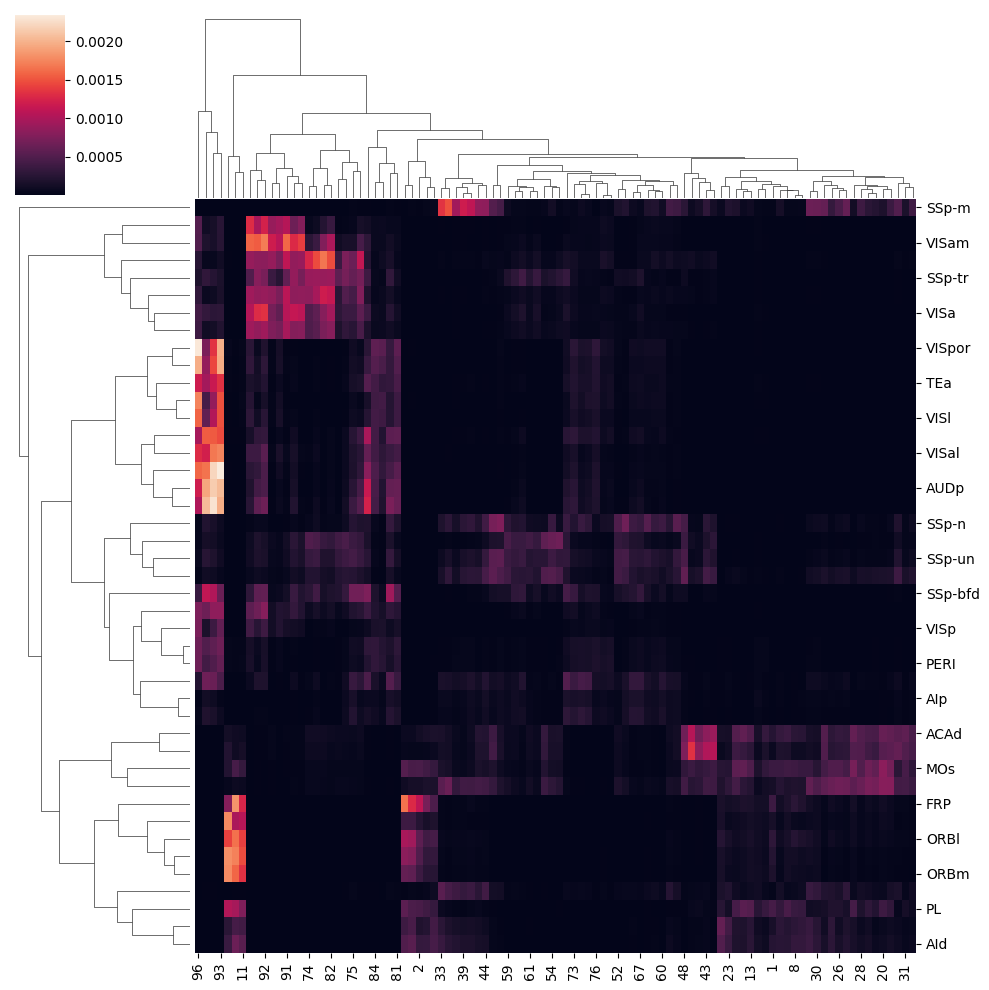

In [13]:
sns.clustermap(ctx2cc_conn, figsize=(10,10))
# sns.heatmap(ctx2cc_conn)
plt.savefig('./cc/cc_raw_heatmap.pdf', format='pdf')

In [6]:
columns_to_drop = [col for col in ctx2cc_conn.columns if (ctx2cc_conn[col] < 0.001).all()]
columns_to_drop

['ECT',
 'SSp-un',
 'SSp-tr',
 'SSp-n',
 'AIv',
 'VISrl',
 'AIp',
 'PERI',
 'SSp-ul',
 'GU',
 'VISp',
 'MOs',
 'RSPagl',
 'MOp',
 'VISC',
 'SSs',
 'SSp-ll',
 'AId']

In [7]:
rows_to_drop = ctx2cc_conn[(ctx2cc_conn < 0.001).all(axis=1)].index
len(rows_to_drop)

67

In [8]:
ctx2cc_conn.drop(columns=columns_to_drop, inplace=True)
ctx2cc_conn.drop(index=rows_to_drop, inplace=True)
# ctx2cc_conn

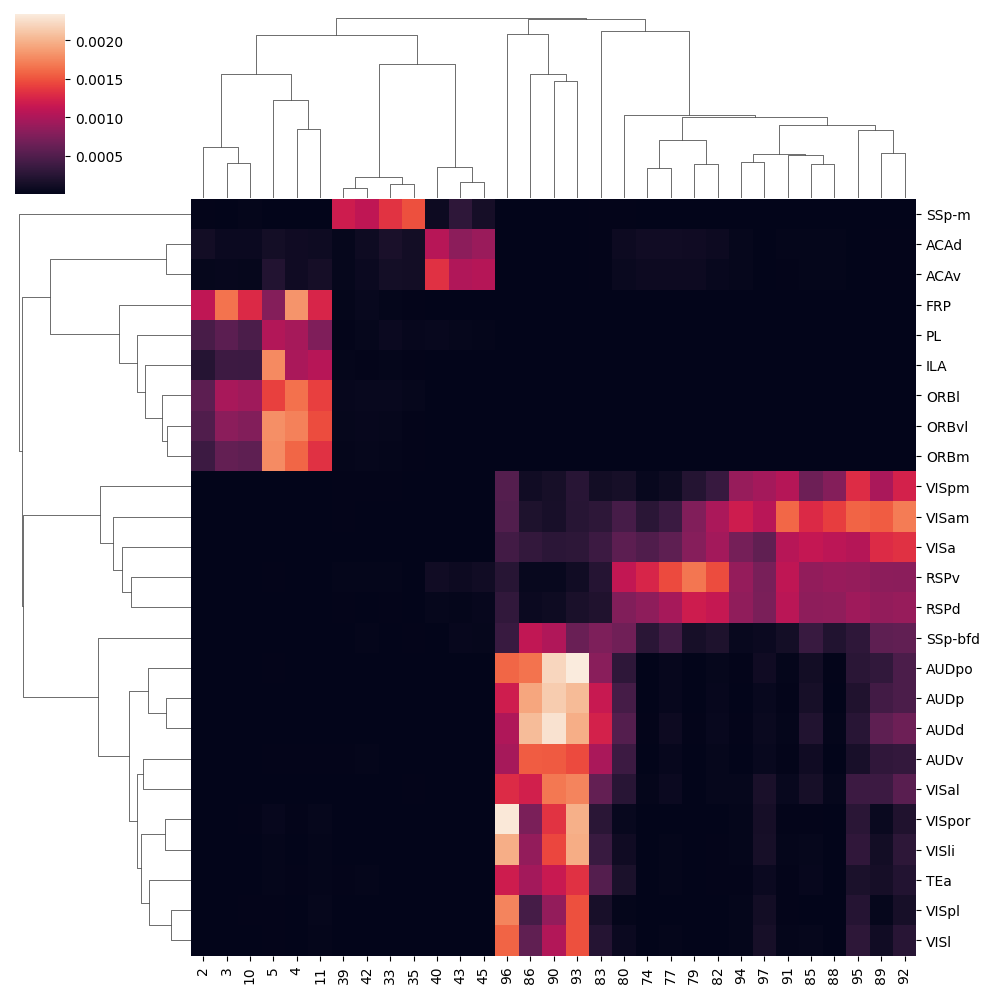

In [19]:
import scipy.cluster.hierarchy as sch
import numpy as np

# Customized rows and columns level clustering
# Here, use the Linkage function of Scipy to generate hierarchical clustering
row_linkage = sch.linkage(ctx2cc_conn, method='single')
col_linkage = sch.linkage(ctx2cc_conn.T, method='single')

# Draw clustermap with custom cluster
g = sns.clustermap(ctx2cc_conn, row_linkage=row_linkage, col_linkage=col_linkage)
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
plt.savefig('./cc/cc_sel_heatmap.pdf', format='pdf')

##### cluster cc

In [10]:
from scipy.cluster import hierarchy
col_linkage = g.dendrogram_col.linkage
col_clusters = hierarchy.fcluster(col_linkage, t=0.5, criterion='distance')
reordered_cols = g.dendrogram_col.reordered_ind
col_labels = np.array(ctx2cc_conn.columns)[reordered_cols]
col_labels

array(['RSPv', 'RSPd', 'VISpm', 'VISa', 'VISam', 'SSp-bfd', 'VISpor',
       'VISli', 'TEa', 'VISpl', 'VISl', 'AUDv', 'VISal', 'AUDpo', 'AUDp',
       'AUDd', 'FRP', 'ORBl', 'ORBvl', 'ORBm', 'PL', 'ILA', 'SSp-m',
       'ACAd', 'ACAv'], dtype=object)

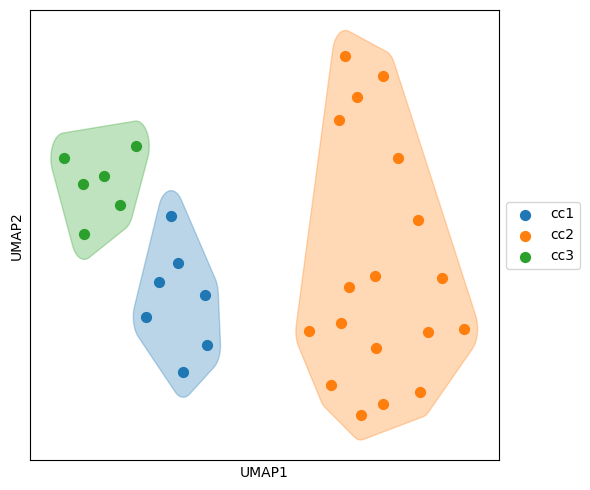

In [11]:
# Use UMAP for 2D dimension reduction
reducer = umap.UMAP(n_components=2, random_state=0)
embedding = reducer.fit_transform(ctx2cc_conn)

# Classification of UMAP results
n_clusters=3

from sklearn.mixture import GaussianMixture
# Use GMM for clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=0)
gmm.fit(embedding)
clusters = gmm.predict(embedding)

# Convert Embedding to DataFrame for easy operation
embedding_df = pd.DataFrame(embedding, index=ctx2cc_conn.index, columns=['UMAP1', 'UMAP2'])
embedding_df['Cluster'] = clusters

# Get discrete color board
# color_list = plt.cm.tab10(np.linspace(0, 1, n_clusters))
color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd','#8c564b', '#17becf', '#e377c2']

fig, ax = plt.subplots(figsize=(6, 5))
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
# Draw a 2D UMAP diagram with clustering results
for cluster in range(n_clusters):
    subset = embedding_df[embedding_df['Cluster'] == cluster]
    points = subset[['UMAP1', 'UMAP2']].values
    
    # Get color
    color = color_list[cluster]
    
    # Draw a scattered point map
    ax.scatter(subset['UMAP1'], subset['UMAP2'], color=color, label=f'cc{cluster+1}', s=50, alpha=1,
                )
    
    # Calculate and draw the expanded and smooth convex bag
    if len(points) > 2:  # Ne convex bags require at least 3 points
        hull = ConvexHull(points)
        hull_points = points[hull.vertices]
        
        # Create polygon and expand
        poly = Polygon(hull_points).buffer(0.2)
        # Make the polygon smoother
        smooth_poly = poly.buffer(0.2, resolution=16, join_style=1).buffer(-0.2, resolution=16, join_style=1)
        # Get the coordinates of polygonal shape
        x, y = smooth_poly.exterior.xy
        # Draw a smooth polygon
        ax.fill(x, y, alpha=0.3, fc=color, ec=color)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
# plt.savefig('./cc/cc_conn_umap.pdf', format='pdf')

In [12]:
embedding_df['Cluster'] = embedding_df['Cluster'].astype(str)

In [13]:
cc_df_sel = pd.DataFrame(columns=['x', 'y', 'c'])
coor = [cc_coor[i] for i in embedding_df.index]
coor = np.array(coor)
cc_df_sel[['x', 'y']] = coor[:, :2]
cc_df_sel['c'] = embedding_df['Cluster'].values
cc_df_sel

,x,y,c
0,43,35,2
1,43,36,2
2,43,37,2
3,43,38,2
4,44,36,2
5,44,37,2
6,50,30,0
7,51,29,0
8,52,29,0
9,53,26,0


In [14]:
cc_df_all = pd.DataFrame(columns=['x', 'y'])
coor = [cc_coor[i] for i in ctx2cc_conn_raw.columns]
coor = np.array(coor)
cc_df_all[['x', 'y']] = coor[:, :2]
# cc_df_tmp['c'] = embedding_df['Cluster'].values
cc_df_all

,x,y
0,43,33
1,43,34
2,43,35
3,43,36
4,43,37
...,...,...
93,74,18
94,75,16
95,75,17
96,75,18


In [15]:
cc_df_tmp = pd.merge(cc_df_all, cc_df_sel, on=['x', 'y'], how='left')
cc_df_tmp

,x,y,c
0,43,33,NaN
1,43,34,NaN
2,43,35,2
3,43,36,2
4,43,37,2
...,...,...,...
93,74,18,1
94,75,16,1
95,75,17,1
96,75,18,1


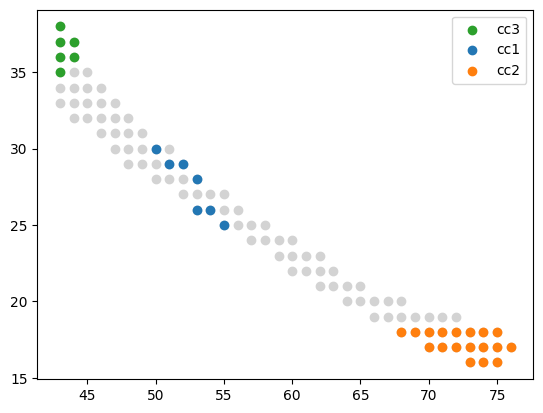

In [16]:
categories = cc_df_sel['c'].unique()
# Draw the scattered point for each category
plt.scatter(cc_df_all['x'], cc_df_all['y'], color = '#D3D3D3')
cm = ['#2ca02c', '#2377b4', '#ff7f0e']
i=0
for category in categories:
    subset = cc_df_sel[cc_df_sel['c'] == category]
    plt.scatter(subset['x'], subset['y'], label=f'cc{int(category)+1}', color=cm[i])
    i=i+1
plt.legend()
# plt.savefig('./cc/cc.pdf', format='pdf')

In [17]:
th_cluster_order = []
num = []
for i in range(3):
    tmp = embedding_df[embedding_df['Cluster'] == str(i)]
    th_cluster_order = th_cluster_order + tmp.index.tolist()
    num.append(len(tmp))
    # print(tmp.index.tolist())
th_cluster_order

[776,
 838,
 905,
 947,
 962,
 1009,
 1058,
 1915,
 1975,
 2027,
 2035,
 2088,
 2095,
 2148,
 2155,
 2205,
 2214,
 2221,
 2267,
 2276,
 2283,
 2332,
 2341,
 2349,
 2405,
 181,
 189,
 196,
 203,
 291,
 297]

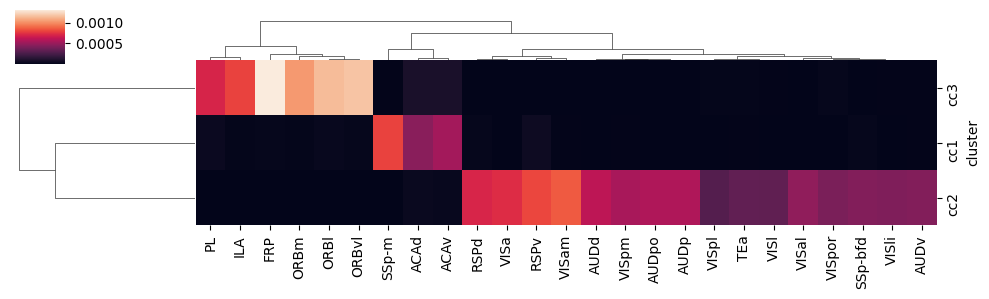

In [19]:
ctx2cc_conn = ctx2cc_conn.loc[th_cluster_order, col_labels]
cluster_labels = ['cc1']*num[0] + ['cc2']*num[1] + ['cc3']*num[2]

ctx2cc_conn['cluster'] = cluster_labels
ctx2cc_conn_cluster_mean = ctx2cc_conn.groupby('cluster').mean()
sns.clustermap(ctx2cc_conn_cluster_mean, figsize=(10, 3))
# plt.savefig('./cc/ctx_cc_conn.pdf', format='pdf')

In [35]:
ctx2cc_conn_cluster_mean.to_csv('./data/ctx_cc_conn_filtered.csv')

### gene exp data

In [20]:
adata_in = sc.read_h5ad('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/adata_processed.h5ad')
allen_region = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/allen_region.csv')
adata_in.obs['region'] = allen_region['region'].values
meta = pd.read_csv('/mnt/Data16Tc/home/haichao/code/SpaCon/Data/N_20231213_zxw/mouse_3/cell_metadata_with_cluster_annotation.csv')
meta = meta.set_index('cell_label')
meta = meta.loc[adata_in.obs.index.to_list()]
adata_in.obs['cell_type'] = meta['class'].to_list()

adata_out = sc.read_h5ad('/mnt/Data18Td/Data/haichao/merfish_raw_data_zxw3/out_cell_adata/adata_out_cell_distance_q0.3/after_qc/Zhuang-ABCA-3.001.h5ad')
# adata_out = sc.read_h5ad('/mnt/Data18Td/Data/haichao/merfish_raw_data_zxw3/out_cell_adata/after_qc/Zhuang-ABCA-3.001.h5ad')
adata_out.obs['region'] = adata_in.obs.loc[adata_out.obs_names]['region'].values

adata_in = adata_in[adata_in.obs['cell_type'].str.contains('Glut')]
adata_out.obs

,totalRNA,brain_section_label,x,y,z,n_genes_by_counts,total_counts,region
100008170567769574864159172860058606533,175,Zhuang-ABCA-3.001,19.063883,33.423346,54.106801,100,175,MOB
100019036144713180485707288452329906643,373,Zhuang-ABCA-3.001,44.290637,63.872748,53.902462,189,373,NDB
10002377904544842423531242460024745973,277,Zhuang-ABCA-3.001,63.860525,7.998013,54.043841,126,277,RSPd2/3
100027648052649525810014127621472143070,435,Zhuang-ABCA-3.001,113.480480,41.056674,54.349928,165,435,arb
100029875144524072265954931895494067096,60,Zhuang-ABCA-3.001,11.572676,37.921554,54.370336,39,60,MOB
...,...,...,...,...,...,...,...,...
99961718914838042706216314325649765172,627,Zhuang-ABCA-3.001,113.199100,23.661374,54.096322,157,627,CENT3
9996242280180655885872867452807576494,157,Zhuang-ABCA-3.001,86.896566,18.326938,54.027272,100,157,SCop
999921392501518309214993564089572563,97,Zhuang-ABCA-3.001,21.082878,31.635078,54.090905,67,97,ORBm1
99995909784199304193294645747252265238,154,Zhuang-ABCA-3.001,111.605478,22.417974,54.070819,93,154,CENT3


In [21]:
gene_com = list(set(adata_in.var_names) & set(adata_out.var_names))
adata_in = adata_in[:, gene_com]
adata_out = adata_out[:, gene_com]

In [22]:
adata_ctx = adata_in[adata_in.obs['region'].str.startswith(tuple(ctx2cc_conn_cluster_mean.columns))]
adata_ctx

View of AnnData object with n_obs × n_vars = 67823 × 1111
    obs: 'brain_section_label', 'x', 'y', 'z', 'x_ccf', 'y_ccf', 'z_ccf', 'region', 'cell_type'

In [24]:

ctx1 = ['SSp-m', 'ACAd', 'ACAv']
ctx2=['RSPv','RSPd', 'VISpm', 'VISa', 'VISam', 'SSp-bfd', 'VISpor', 'VISli', 'TEa', 'VISpl', 'VISl', 'AUDv', 'VISal', 'AUDpo', 'AUDp', 'AUDd']
ctx3 = ['FRP', 'ORBl', 'ORBvl', 'ORBm', 'PL', 'ILA']
adata_ctx.obs['cc_ctx'] = None
adata_ctx.obs.loc[adata_ctx.obs['region'].str.startswith(tuple(ctx1)), 'cc_ctx'] = 'ctx1'
adata_ctx.obs.loc[adata_ctx.obs['region'].str.startswith(tuple(ctx2)), 'cc_ctx'] = 'ctx2'
adata_ctx.obs.loc[adata_ctx.obs['region'].str.startswith(tuple(ctx3)), 'cc_ctx'] = 'ctx3'
# adata_ctx.obs.loc[adata_ctx.obs['region'].str.startswith(tuple(ctx4['feature'])), 'cc_ctx'] = 'ctx4'
adata_ctx = adata_ctx[adata_ctx.obs['cc_ctx'].notna()]

def split_string(s):
    parts = re.split(r'(\d+)', s)
    return parts[0] if parts else ''
adata_ctx.obs['region_corr'] = adata_ctx.obs['region'].apply(split_string)
adata_ctx.obs


,brain_section_label,x,y,z,x_ccf,y_ccf,z_ccf,region,cell_type,cc_ctx,region_corr
cell_label,,,,,,,,,,,
26411547786725657279968630020392489253,Zhuang-ABCA-3.023,70.979368,44.436003,12.009219,7.097937,4.443600,1.200922,TEa5,02 NP-CT-L6b Glut,ctx2,TEa
51881204226374601340923791448380690325,Zhuang-ABCA-3.023,71.048105,43.963880,11.994586,7.104811,4.396388,1.199459,TEa5,02 NP-CT-L6b Glut,ctx2,TEa
9451154036366067416684391406873704139,Zhuang-ABCA-3.023,70.906348,44.496406,12.010524,7.090635,4.449641,1.201052,TEa5,01 IT-ET Glut,ctx2,TEa
171871543800699640490603639355149752394,Zhuang-ABCA-3.023,71.407038,43.722307,11.991027,7.140704,4.372231,1.199103,TEa5,01 IT-ET Glut,ctx2,TEa
103032537075799430231760598323601697566,Zhuang-ABCA-3.023,71.756868,42.845081,11.969093,7.175687,4.284508,1.196909,TEa5,01 IT-ET Glut,ctx2,TEa
...,...,...,...,...,...,...,...,...,...,...,...
76782871153522898745220481389975181375,Zhuang-ABCA-3.009,99.188067,15.861129,38.190379,9.918807,1.586113,3.819038,RSPd2/3,01 IT-ET Glut,ctx2,RSPd
787969273575687407995158747342318857,Zhuang-ABCA-3.009,99.457911,15.644515,38.208613,9.945791,1.564451,3.820861,RSPd2/3,01 IT-ET Glut,ctx2,RSPd
90320078306590901695895422976195202341,Zhuang-ABCA-3.009,99.669320,15.954429,38.226878,9.966932,1.595443,3.822688,RSPd1,01 IT-ET Glut,ctx2,RSPd


In [25]:
regions = adata_ctx.obs['region_corr'].values
gene_expression = adata_ctx.X.A
# Create a DataFrame, integrate regional information and gene expression matrix
df = pd.DataFrame(gene_expression, columns=adata_ctx.var_names)
df['region_corr'] = regions
#Colonally group and calculate the average gene expression
ctx_region_mean_expression = df.groupby('region_corr').mean()
# Convert the result to the matrix format of the area*gene
ctx_region_gene_matrix = ctx_region_mean_expression.values
ctx_region_gene_matrix.shape

(25, 1111)

100%|██████████| 1187/1187 [00:00<00:00, 32725.57it/s]


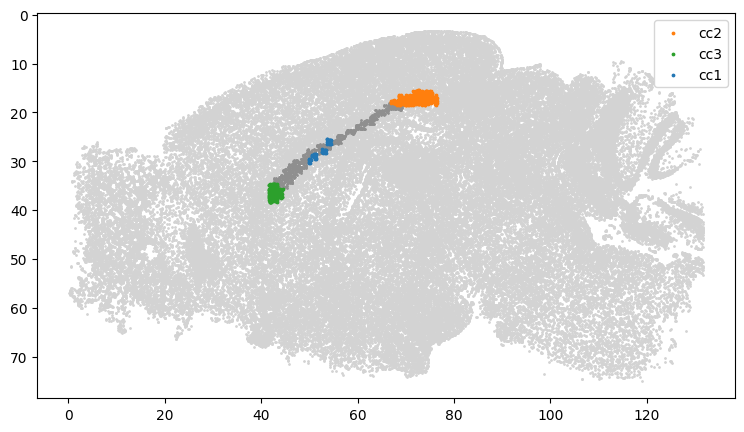

In [26]:
adata_cc = adata_out[adata_out.obs['region'].str.startswith('cc')]
tmp = adata_cc.copy()
idx = []
coordinate = cc_df_tmp[['x', 'y']].values
kdtree = cKDTree(coordinate)
for coord in tqdm(adata_cc.obs[['x', 'y']].values):
    # Query recent neighbor indexes
    _, nearest_index = kdtree.query(coord)
    idx.append(nearest_index)
plt.figure(figsize=(9,5))
### match the cc cluster
adata_cc.obs['NT_index'] = idx
adata_cc.obs['cc'] = cc_df_tmp.loc[adata_cc.obs['NT_index']]['c'].values
adata_cc = adata_cc[adata_cc.obs['cc'].notna()]
adata_cc.obs['cc'] = 'cc'+((adata_cc.obs['cc']).astype(int)+1).astype(str)
#### plot
categories = adata_cc.obs['cc'].unique()
plt.scatter(adata_out.obs['x'], adata_out.obs['y'], s=1, c='#d3d3d3')
plt.scatter(tmp.obs['x'], tmp.obs['y'], s=1, c='#8f8f8f')

# Draw the scattered point for each category
cm = ['#ff7f0e', '#2ca02c', '#2377b4']
# cm = ['#6597b9', '#6bad6b', '#e9a161']
i=0
for category in categories:
    subset = adata_cc[adata_cc.obs['cc'] == category]
    plt.scatter(subset.obs['x'], subset.obs['y'], label=category, s=3, c=cm[i])
    # print(f'cc_{int(category)}')
    i=i+1
plt.legend()
plt.gca().invert_yaxis()
# plt.savefig('cc_area.png', dpi=600)

#### region conn & corr

In [27]:
adata_cc.obs['region_corr'] = adata_cc.obs['cc']
adata_cc.obs

,totalRNA,brain_section_label,x,y,z,n_genes_by_counts,total_counts,region,NT_index,cc,region_corr
100699349310225087355794400029769253599,289,Zhuang-ABCA-3.001,67.394394,17.726380,54.104598,138,289,ccb,74,cc2,cc2
100902451446327482578212394659210886364,65,Zhuang-ABCA-3.001,43.321564,36.220293,54.177884,47,65,ccg,3,cc3,cc3
101091759418520737635298400963209655403,282,Zhuang-ABCA-3.001,70.727172,17.820763,54.078071,104,282,ccs,83,cc2,cc2
101177908791681271480760545204792047403,357,Zhuang-ABCA-3.001,53.695160,26.428293,54.015113,124,357,ccb,43,cc1,cc1
101227086293358235805510357201736468429,239,Zhuang-ABCA-3.001,41.673989,36.956672,54.114538,115,239,ccg,4,cc3,cc3
...,...,...,...,...,...,...,...,...,...,...,...
96560296481515876710645847659207426556,58,Zhuang-ABCA-3.001,43.282826,35.133529,54.189423,39,58,ccg,2,cc3,cc3
96578052950946015015587401781979033053,101,Zhuang-ABCA-3.001,72.815062,15.920409,54.055571,59,101,ccs,88,cc2,cc2
96728852215317096694357846973382843058,100,Zhuang-ABCA-3.001,41.845540,34.861770,54.158130,69,100,ccg,2,cc3,cc3
97838821125536355149234993233022684525,133,Zhuang-ABCA-3.001,70.380641,18.437770,54.082850,83,133,ccb,80,cc2,cc2


In [28]:
adata_cc_ctx = ad.concat([adata_ctx, adata_cc])
adata_cc_ctx

AnnData object with n_obs × n_vars = 68321 × 1111
    obs: 'brain_section_label', 'x', 'y', 'z', 'region', 'region_corr'

In [29]:
sc.pp.normalize_total(adata_cc_ctx, target_sum=1e4)
sc.pp.log1p(adata_cc_ctx)
adata_cc_ctx

AnnData object with n_obs × n_vars = 68321 × 1111
    obs: 'brain_section_label', 'x', 'y', 'z', 'region', 'region_corr'
    uns: 'log1p'

#### conn & corr

In [30]:
regions = adata_cc_ctx.obs['region_corr'].values
gene_expression = adata_cc_ctx.X.A

# Create a DataFrame to integrate regional information and gene expression matrix together
df = pd.DataFrame(gene_expression, columns=adata_cc_ctx.var_names)
df['region_corr'] = regions

# Calculate the average gene expression by regional grouping and calculate the average gene
region_mean_expression = df.groupby('region_corr').mean()
# Convert the result to the matrix format of the regional*gene
region_gene_matrix = region_mean_expression.values
region_gene_matrix.shape

(28, 1111)

In [31]:
corr_all = np.corrcoef(region_gene_matrix)
corr_all.shape

(28, 28)

In [32]:
cc = [f'cc{i+1}' for i in range(n_clusters)]
cc

['cc1', 'cc2', 'cc3']

In [33]:
cc_subregions = adata_cc_ctx[adata_cc_ctx.obs['region'].str.startswith('cc')].obs['region_corr'].unique()
ctx_subregions = adata_cc_ctx[adata_cc_ctx.obs['region'].str.startswith(tuple(ctx_43_regions))].obs['region_corr'].unique()

region_labels = region_mean_expression.index
ctx_indices = [i for i, label in enumerate(region_labels) if label in ctx_subregions]
cc_indices = [i for i, label in enumerate(region_labels) if label in cc_subregions]
corr = corr_all[np.ix_(ctx_indices, cc_indices)]

ctx_regions_df = [region_labels[i] for i in ctx_indices]
cc_regions_df = [region_labels[i] for i in cc_indices]
corr_df = pd.DataFrame(corr, index=ctx_regions_df, columns=cc_regions_df)
corr_df.columns = cc
corr_df

,cc1,cc2,cc3
ACAd,0.278914,0.262625,0.301169
ACAv,0.281494,0.265369,0.304893
AUDd,0.288976,0.261093,0.312110
AUDp,0.298039,0.275037,0.320481
AUDpo,0.289891,0.262205,0.313013
AUDv,0.298164,0.277583,0.321607
FRP,0.277721,0.246925,0.296658
ILA,0.247419,0.234853,0.275192
ORBl,0.289135,0.269547,0.309606
ORBm,0.269378,0.250819,0.295708


In [34]:
ctx2cc_conn_cluster_mean = pd.read_csv('./data/ctx_cc_conn_filtered.csv')
ctx2cc_conn_cluster_mean = ctx2cc_conn_cluster_mean.transpose()
ctx2cc_conn_cluster_mean = ctx2cc_conn_cluster_mean.loc[corr_df.index]
ctx2cc_conn_cluster_mean

cluster,cc1,cc2,cc3
ACAd,0.000454,3.466430e-05,9.106244e-05
ACAv,0.000533,2.746207e-05,9.169748e-05
AUDd,0.000002,6.115146e-04,1.393698e-06
AUDp,0.000003,5.699260e-04,4.200837e-06
AUDpo,0.000003,5.697359e-04,4.588037e-06
AUDv,0.000007,4.365286e-04,8.039079e-06
FRP,0.000018,3.140131e-07,1.314226e-03
ILA,0.000013,1.089208e-06,7.981067e-04
ORBl,0.000029,6.969948e-07,1.154751e-03
ORBm,0.000014,8.764364e-07,1.038650e-03


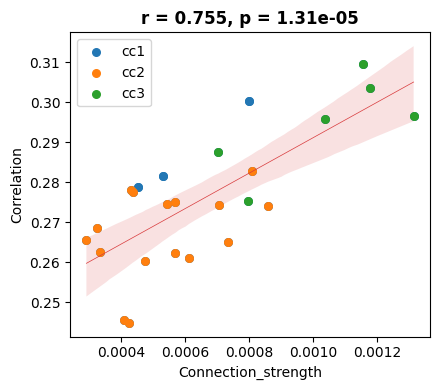

In [38]:
df1_long = corr_df.reset_index().melt(id_vars='index', var_name='cc', value_name='Correlation')
df2_long = ctx2cc_conn_cluster_mean.reset_index().melt(id_vars='index', var_name='cc', value_name='Connection_strength')
# Merge two long format dataframe
df_merged = pd.merge(df1_long, df2_long, on=['index', 'cc'])
df_merged = df_merged[df_merged['Connection_strength'] > 0.0001]
# Calculate the number of phase relationships and P value
correlation, p_value = pearsonr(df_merged['Correlation'], df_merged['Connection_strength'])

# Draw chart
plt.figure(figsize=(4.5, 4))
sns.regplot(data=df_merged, x='Connection_strength', y='Correlation',
            scatter_kws={'s': 30, 'alpha': 1},
            line_kws={'linewidth': 0.5, 'color': '#D8383A', 'linestyle': '-'})

# Set different colors according to CC1, CC2, CC3
colors = ['#2377b4', '#ff7f0e', '#2ca02c']

for i, c in enumerate(cc):
    subset = df_merged[df_merged['cc'] == c]  
    plt.scatter(subset['Connection_strength'], subset['Correlation'], s=30, color=colors[i], label=c)

plt.title(f'r = {correlation:.3f}, p = {p_value:.2e}', fontweight='bold')
plt.legend()

plt.tight_layout()
# plt.show()
# plt.savefig('cc_ctx_corr.pdf', format='pdf')